# ISL Alphabet Classification with CNN (Keras)

This notebook trains a simple Convolutional Neural Network (CNN) to classify ISL alphabet signs using the ISL-HS dataset.


In [1]:
# Imports & Constants
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Constants
DATA_DIR = "../ISL/Frames"
IMG_SIZE = (64, 64)
NUM_CLASSES = 23  # A–Y (excluding J, X, Z)


In [2]:
# Load Dataset
def extract_label(filename):
    parts = filename.split("-")
    if len(parts) >= 3:
        return parts[1].upper()
    return None

def load_data(data_dir):
    X, y = [], []
    for person_folder in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person_folder)
        if not os.path.isdir(person_path):
            continue
        for fname in os.listdir(person_path):
            if not fname.endswith(".jpg"):
                continue
            label = extract_label(fname)
            if label in ["J", "X", "Z"]:
                continue  # skip dynamic signs
            img_path = os.path.join(person_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

print("Loading data...")
X, y = load_data(DATA_DIR)
print(f"Loaded {len(X)} images.")


Loading data...
Loaded 52688 images.


In [3]:
# Preprocess
X = X.astype("float32") / 255.0
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (36881, 64, 64, 1), Test: (15807, 64, 64, 1)


In [4]:
# Build CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/Users/rharris/college/PRO/deafInclusionTool/comharthai/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,543 (6.21 MB)

 Trainable params: 1,627,543 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.2005 - loss: 2.6215 - val_accuracy: 0.7839 - val_loss: 0.7159
Epoch 2/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7001 - loss: 0.8655 - val_accuracy: 0.9414 - val_loss: 0.2447
Epoch 3/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.8424 - loss: 0.4469 - val_accuracy: 0.9622 - val_loss: 0.1308
Epoch 4/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.8931 - loss: 0.2944 - val_accuracy: 0.9715 - val_loss: 0.0854
Epoch 5/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9170 - loss: 0.2219 - val_accuracy: 0.9771 - val_loss: 0.0612
Epoch 6/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9372 - loss: 0.1765 - val_accuracy: 0.9848 - val_loss: 0.0410
Epoch 7/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9457 - loss: 0.1473 - val_accuracy: 0.9862 - val_loss: 0.0366
Epoch 8/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9508 - loss: 0.1312 - 

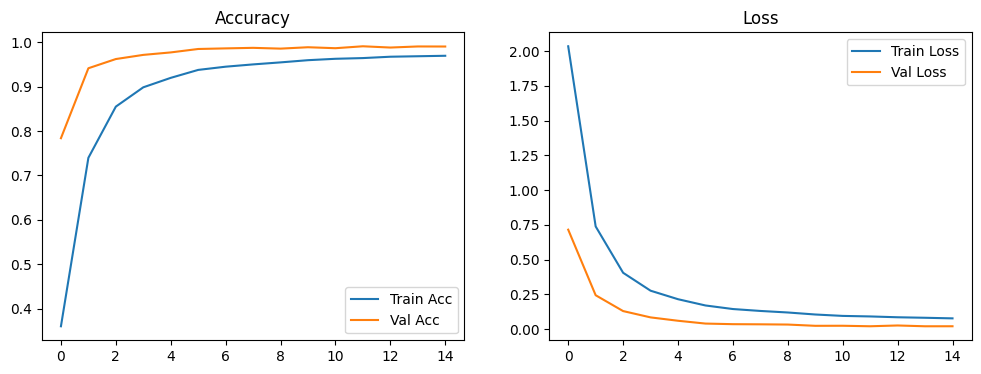

In [6]:
# Plot Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()


494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9897 - loss: 0.0217
Test Accuracy: 0.9898
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


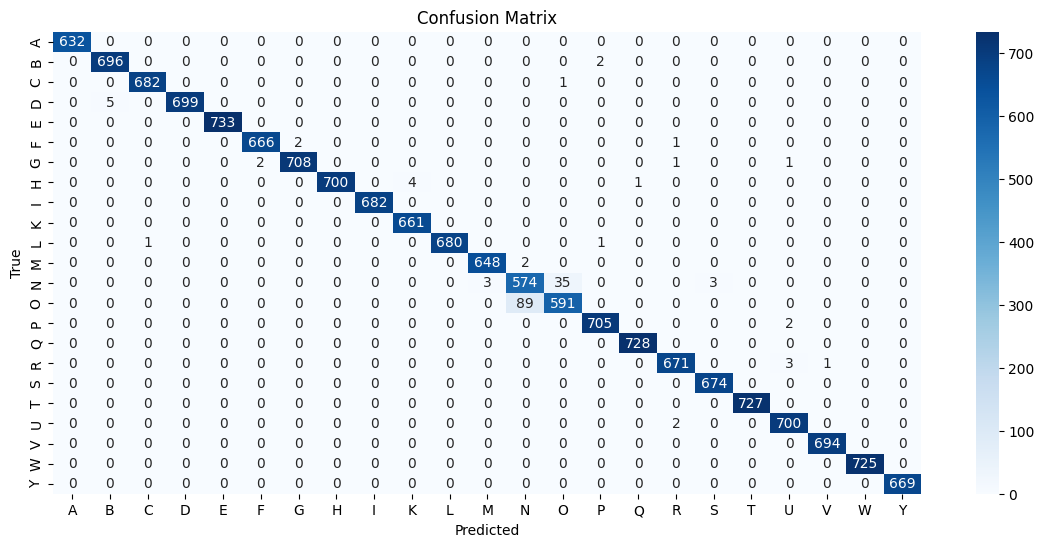

In [7]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = lb.inverse_transform(y_pred)
y_true_labels = lb.inverse_transform(y_test)

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=lb.classes_)
plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
# Save Model
model.save("isl_cnn_model.keras")
print("Model saved to isl_cnn_model.keras")


Model saved to isl_cnn_model.keras
